In [102]:
import anndata
import pandas as pd
import scanpy as sc
import cstarpy
import os
import numpy as np
from cstarpy.separation import CellStateTransition
import seaborn as sns
from scipy.io import mmread

In [103]:
os.chdir('/home/jing/Phd_project/project_GBM/gbm_OUTPUT_sctransform/')

In [8]:
def load_mtx_as_dataframe(data):
    # Read sparse matrix
    mtx = mmread(f"gbm_OUTPUT_sct_tumor_{data}_corrected_UMI.mtx").toarray()  # Convert to dense array
    
    # Read cell and gene names
    cells = pd.read_csv(f"gbm_OUTPUT_sct_tumor_{data}_corrected_UMI_cells.txt", header=None)[0].tolist()
    genes = pd.read_csv(f'gbm_OUTPUT_sct_tumor_{data}_corrected_UMI_genes.txt', header=None)[0].tolist()
    
    # Convert to DataFrame
    df = pd.DataFrame(mtx, index=cells, columns=genes)
    
    return df


In [116]:
#For lincs data
def subset(data):
    mtx =f"gbm_OUTPUT_sct_tumor_{data}_corrected_UMI.mtx"
    cells=pd.read_csv(f"gbm_OUTPUT_sct_tumor_{data}_corrected_UMI_cells.txt",header=None)
    features=pd.read_csv(f'gbm_OUTPUT_sct_tumor_{data}_corrected_UMI_genes.txt',header=None)
    adata = sc.read_mtx(mtx)
    
    adata.obs['CellID']= cells[0].tolist()
    adata.var['Gene']= features[0].tolist()
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata,base=2)
    adata_subset_df=adata.to_df()
    print(adata_subset_df)

    return(adata_subset_df)


In [120]:

def subset(data):
    # Read the required files
    mtx = f"gbm_OUTPUT_sct_tumor_{data}_corrected_UMI.mtx"
    cells = pd.read_csv(f"gbm_OUTPUT_sct_tumor_{data}_corrected_UMI_cells.txt", header=None)
    features = pd.read_csv(f'gbm_OUTPUT_sct_tumor_{data}_corrected_UMI_genes.txt', header=None)
    
    # Load the matrix into AnnData
    adata = sc.read_mtx(mtx)
    
    # Assign cell and gene names to the AnnData object
    adata.obs['CellID'] = cells[0].tolist()
    adata.var['Gene'] = features[0].tolist()
    
    # Make sure gene names are unique
    adata.var.index = adata.var['Gene']
    adata.var_names_make_unique()

    # Preprocessing: Normalize and log-transform the data
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata, base=2)

    # Convert AnnData object to DataFrame, setting the row index to 'CellID'
    adata_subset_df = adata.to_df()
    adata_subset_df.index = adata.obs['CellID']  # Ensure the row index is set to CellID

    # Check the resulting DataFrame
    print(adata_subset_df)

    return adata_subset_df


In [121]:
prm_log2= subset('prm')

Gene                        RP11-34P13.7  FO538757.2  AP006222.2  \
CellID                                                             
SF11082_AAACCCAAGCATCAAA-1           0.0    0.000000         0.0   
SF11082_AAACCCAAGGCACGAT-1           0.0    0.000000         0.0   
SF11082_AAACCCAGTAAGCGGT-1           0.0    0.000000         0.0   
SF11082_AAACCCAGTTGTGTAC-1           0.0    0.000000         0.0   
SF11082_AAACCCATCTGGAGAG-1           0.0    0.000000         0.0   
...                                  ...         ...         ...   
SF9798_TTTGGTTGTTGCCGAC-1            0.0    2.124355         0.0   
SF9798_TTTGGTTTCTGCATGA-1            0.0    0.000000         0.0   
SF9798_TTTGGTTTCTGTCCGT-1            0.0    0.000000         0.0   
SF9798_TTTGTTGAGATGACAT-1            0.0    3.669358         0.0   
SF9798_TTTGTTGTCCTACACC-1            0.0    2.736053         0.0   

Gene                        RP4-669L17.10  RP5-857K21.4  RP11-206L10.9  \
CellID                                   

In [122]:
rct_log2= subset('rct')

Gene                        RP11-34P13.7  FO538757.2  AP006222.2  \
CellID                                                             
SF11488_AAACCCAAGCGTGAGT-1           0.0    2.856437    0.000000   
SF11488_AAACCCAAGGTCACTT-1           0.0    0.000000    0.000000   
SF11488_AAACCCAAGTCATACC-1           0.0    0.000000    0.000000   
SF11488_AAACCCAGTGCCGGTT-1           0.0    0.000000    2.965063   
SF11488_AAACCCAGTTAACCTG-1           0.0    0.000000    0.000000   
...                                  ...         ...         ...   
SF9962_TTTGACTAGTTTGGCT-1            0.0    0.000000    0.000000   
SF9962_TTTGACTGTGCGGATA-1            0.0    0.000000    0.000000   
SF9962_TTTGATCTCGAGATAA-1            0.0    0.000000    0.000000   
SF9962_TTTGATCTCGGCGATC-1            0.0    0.000000    0.000000   
SF9962_TTTGTTGGTCATTCCC-1            0.0    0.000000    0.000000   

Gene                        RP4-669L17.10  RP5-857K21.4  RP11-206L10.9  \
CellID                                   

In [123]:
common_genes = rct_log2.columns.intersection(lm_df.index)
common_genes = prm_log2.columns.intersection(common_genes)
len(common_genes)
rct_tumor_lincs = rct_log2[common_genes]
pmr_tumor_lincs = prm_log2[common_genes]
print(rct_tumor_lincs.shape,pmr_tumor_lincs.shape)

cst_lincs = CellStateTransition('p_r_tumor', rct_tumor_lincs, pmr_tumor_lincs)
dpd_scores_lincs = cst_lincs.get_dpd()

norm_s_lincs = pd.DataFrame(np.stack([cst_lincs.n, cst_lincs.s], axis=1), index=cst_lincs.svm_input.data.columns, columns=["n", "s"])

print(cst_lincs.h)

(19435, 943) (19588, 943)
0.5041712499949051


In [119]:
prm_log2.reset_index()

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '19578', '19579', '19580', '19581', '19582', '19583', '19584', '19585',
       '19586', '19587'],
      dtype='object', length=19588)

In [11]:
pmr_tumor_df = load_mtx_as_dataframe("prm")
print(pmr_tumor_df.shape)
print(pmr_tumor_df.head())

(19588, 26221)
                            RP11-34P13.7  FO538757.2  AP006222.2  \
SF11082_AAACCCAAGCATCAAA-1           0.0         0.0         0.0   
SF11082_AAACCCAAGGCACGAT-1           0.0         0.0         0.0   
SF11082_AAACCCAGTAAGCGGT-1           0.0         0.0         0.0   
SF11082_AAACCCAGTTGTGTAC-1           0.0         0.0         0.0   
SF11082_AAACCCATCTGGAGAG-1           0.0         0.0         0.0   

                            RP4-669L17.10  RP5-857K21.4  RP11-206L10.9  \
SF11082_AAACCCAAGCATCAAA-1            0.0      0.693147       0.000000   
SF11082_AAACCCAAGGCACGAT-1            0.0      0.000000       0.693147   
SF11082_AAACCCAGTAAGCGGT-1            0.0      0.000000       0.000000   
SF11082_AAACCCAGTTGTGTAC-1            0.0      0.000000       0.000000   
SF11082_AAACCCATCTGGAGAG-1            0.0      0.000000       0.000000   

                            RP11-54O7.16  RP11-54O7.3  SAMD11     NOC2L  ...  \
SF11082_AAACCCAAGCATCAAA-1           0.0          0

In [12]:
rct_tumor_df = load_mtx_as_dataframe("rct")
print(rct_tumor_df.shape)
print(rct_tumor_df.head())

(19435, 26221)
                            RP11-34P13.7  FO538757.2  AP006222.2  \
SF11488_AAACCCAAGCGTGAGT-1           0.0    0.693147    0.000000   
SF11488_AAACCCAAGGTCACTT-1           0.0    0.000000    0.000000   
SF11488_AAACCCAAGTCATACC-1           0.0    0.000000    0.000000   
SF11488_AAACCCAGTGCCGGTT-1           0.0    0.000000    0.693147   
SF11488_AAACCCAGTTAACCTG-1           0.0    0.000000    0.000000   

                            RP4-669L17.10  RP5-857K21.4  RP11-206L10.9  \
SF11488_AAACCCAAGCGTGAGT-1            0.0      0.000000       0.000000   
SF11488_AAACCCAAGGTCACTT-1            0.0      0.000000       0.000000   
SF11488_AAACCCAAGTCATACC-1            0.0      1.098612       0.000000   
SF11488_AAACCCAGTGCCGGTT-1            0.0      0.000000       0.000000   
SF11488_AAACCCAGTTAACCTG-1            0.0      0.000000       0.693147   

                            RP11-54O7.16  RP11-54O7.3    SAMD11  NOC2L  ...  \
SF11488_AAACCCAAGCGTGAGT-1      0.000000     0.00000

In [81]:
cst_full = CellStateTransition('p_r_tumor_full', rct_tumor_df, pmr_tumor_df)

In [84]:
dpd_scores = cst_full.get_dpd()

norm_s = pd.DataFrame(np.stack([cst_full.n, cst_full.s], axis=1), index=cst_full.svm_input.data.columns, columns=["n", "s"])

print(cst_full.h)

0.09386663650536159


In [85]:
dpd_scores['Sample'] = dpd_scores.index.str.split('_').str[0]

In [88]:
dpd_scores['Stage'] ='Recurrent'
for i in ['SF2770', 'SF2990', 'SF3076', 'SF3391', 'SF11916', 'SF11082', 'SF9358', 'SF9798']:
    dpd_scores.loc[dpd_scores['Sample'].str.contains(i, na=False), 'Stage'] = 'Primary'

In [89]:
dpd_scores


,DPD_p_r_tumor_full,Sample,Stage
SF11488_AAACCCAAGCGTGAGT-1,-0.557442,SF11488,Recurrent
SF11488_AAACCCAAGGTCACTT-1,-1.314969,SF11488,Recurrent
SF11488_AAACCCAAGTCATACC-1,-1.555289,SF11488,Recurrent
SF11488_AAACCCAGTGCCGGTT-1,-0.931028,SF11488,Recurrent
SF11488_AAACCCAGTTAACCTG-1,-0.979602,SF11488,Recurrent
...,...,...,...
SF9798_TTTGGTTGTTGCCGAC-1,0.314387,SF9798,Primary
SF9798_TTTGGTTTCTGCATGA-1,0.572064,SF9798,Primary
SF9798_TTTGGTTTCTGTCCGT-1,1.446963,SF9798,Primary
SF9798_TTTGTTGAGATGACAT-1,0.316784,SF9798,Primary


In [90]:
dpd_scores['zeros'] =0 

<Axes: xlabel='DPD_p_r_tumor_full', ylabel='zeros'>

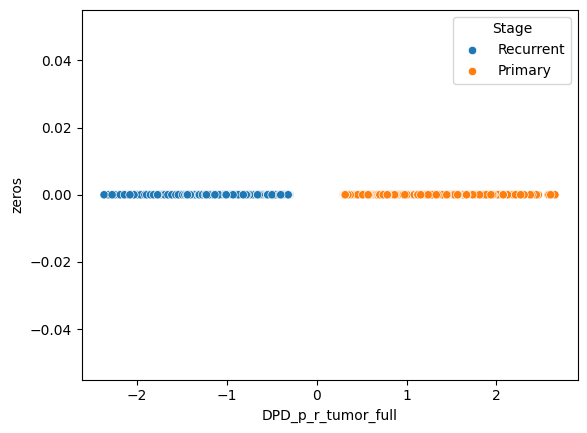

In [95]:
sns.scatterplot(x='DPD_p_r_tumor_full',y='zeros',hue='Stage',data=dpd_scores)

In [47]:
gbm_stv = pd.read_excel('/home/jing/Phd_project/project_GBM/gbm_OUTPUT/gbm_OUTPUT_LINCS/gbm_STVs.xlsx',
                        sheet_name='STVs',index_col=0)

In [68]:
gbm_stv.loc[common_genes,'GBM_onc']

DFFB      0.019947
ICMT     -0.080201
KLHL21   -0.012436
CLSTN1    0.010032
DFFA      0.013415
            ...   
SHB       0.000000
CCNA1     0.000000
GRB7      0.000000
PRR15L    0.000000
MMP1      0.000000
Name: GBM_onc, Length: 943, dtype: float64

In [69]:
dot_product = np.dot(rct_tumor_df[common_genes], gbm_stv.loc[common_genes, 'GBM_onc'])

In [78]:
print(dot_product.max(),dot_product.min())

0.64292669742695 -2.3517412583052164


In [76]:
p_dot_product = np.dot(pmr_tumor_df[common_genes], gbm_stv.loc[common_genes, 'GBM_onc'])

In [79]:
print(p_dot_product.max(),p_dot_product.min())

0.5151309793764076 -1.6806435894585885


In [13]:
lm_df=pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_Scripts/perturbations/01_outputs_2020/L1000_Data_norm_data.csv',index_col=0)
display(lm_df)

,ASG002_BC3C_24H:A10,ASG002_BC3C_24H:A11,ASG002_BC3C_24H:A19,ASG002_BC3C_24H:A20,ASG002_BC3C_24H:A21,ASG002_BC3C_24H:B10,ASG002_BC3C_24H:B11,ASG002_BC3C_24H:B12,ASG002_BC3C_24H:B14,ASG002_BC3C_24H:B15,...,MOAR010_BC3C_24H:K09,MOAR010_BC3C_24H:L19,MOAR010_BC3C_24H:L20,MOAR010_BC3C_24H:L21,MOAR011_BC3C_24H:C01,MOAR011_BC3C_24H:C02,MOAR011_BC3C_24H:C03,MOAR011_BC3C_24H:C10,MOAR011_BC3C_24H:C11,MOAR011_BC3C_24H:J10
AARS,-0.496854,0.288446,0.189747,-0.016454,0.080746,0.282346,0.326246,0.244946,0.303046,0.387546,...,-0.217618,-0.074268,-0.012317,-0.004018,0.215100,-0.178100,-0.007000,0.024000,0.007400,0.031399
ABCB6,-0.658596,-0.142196,-0.075397,-0.383796,-0.199996,-0.074197,0.108804,0.055204,-0.399196,-0.227496,...,0.202852,-0.003798,-0.661323,0.326502,0.127850,0.081150,-0.026850,-0.152851,0.122550,-0.029350
ABCC5,-0.080204,0.231996,-0.329354,-0.225204,0.278446,0.034696,0.396596,0.288746,-0.255704,-0.254154,...,0.011493,0.187043,-0.051357,0.358943,0.197500,0.119350,0.212450,-0.177250,0.138650,0.568950
ABCF1,0.202535,0.602335,0.403335,0.313134,-0.083265,-0.056365,-0.387216,0.104534,0.097235,0.540634,...,-0.458439,1.132361,-0.555990,-0.556689,-0.036825,-0.080325,0.059175,0.307175,0.580075,0.322875
ABCF3,-0.520919,-0.192819,0.001032,-0.096419,0.210881,-0.731118,0.095381,0.049931,0.313481,-0.078018,...,0.201432,-0.028568,0.447982,0.610582,-0.378251,0.003950,0.127300,-0.197401,-0.128351,-0.012850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF395,1.796254,1.773154,0.668354,0.825354,0.350654,0.205954,-0.998346,-0.458247,0.235354,0.230653,...,-0.285181,-1.188080,-0.050680,-1.175880,0.300250,-0.265350,-0.380850,-0.330950,-1.844650,-0.612350
ZNF451,-0.244519,0.116732,0.058081,-0.178169,-0.080619,-0.139119,0.064681,-0.237719,-0.083019,-0.272119,...,0.085807,0.107632,-0.083718,0.105732,-0.324500,0.080550,-0.114950,-0.337650,-0.024950,-0.151550
ZNF586,0.097627,0.061027,-0.337573,0.098427,-0.338173,0.017627,-0.197423,-0.155173,-0.078473,-0.300473,...,0.056085,-0.005365,-0.123664,-0.191564,-0.304650,-0.259400,0.163600,-0.428700,-0.069200,0.073700
ZNF589,0.608573,0.106123,-0.014126,-0.003677,-0.123477,-0.243377,0.044623,0.092123,-0.021477,0.201823,...,-0.200241,-0.027441,0.007359,-0.072891,-0.315500,-0.013900,-0.035050,1.836400,-0.223300,-0.343400


In [20]:
common_genes = rct_tumor_df.columns.intersection(lm_df.index)
common_genes = pmr_tumor_df.columns.intersection(common_genes)
len(common_genes)

943

In [21]:
common_genes = rct_tumor_df.columns.intersection(lm_df.index)
common_genes = pmr_tumor_df.columns.intersection(common_genes)
len(common_genes)
rct_tumor_lincs = rct_tumor_df[common_genes]
pmr_tumor_lincs = pmr_tumor_df[common_genes]
print(rct_tumor_lincs.shape,pmr_tumor_lincs.shape)

(19435, 943) (19588, 943)


In [23]:
common_genes = rct_tumor_df.columns.intersection(lm_df.index)
common_genes = pmr_tumor_df.columns.intersection(common_genes)
len(common_genes)
rct_tumor_lincs = rct_tumor_df[common_genes]
pmr_tumor_lincs = pmr_tumor_df[common_genes]
print(rct_tumor_lincs.shape,pmr_tumor_lincs.shape)
cst_lincs = CellStateTransition('p_r_tumor', rct_tumor_lincs, pmr_tumor_lincs)

In [27]:
common_genes = rct_tumor_df.columns.intersection(lm_df.index)
common_genes = pmr_tumor_df.columns.intersection(common_genes)
len(common_genes)
rct_tumor_lincs = rct_tumor_df[common_genes]
pmr_tumor_lincs = pmr_tumor_df[common_genes]
print(rct_tumor_lincs.shape,pmr_tumor_lincs.shape)
cst_lincs = CellStateTransition('p_r_tumor', rct_tumor_lincs, pmr_tumor_lincs)
dpd_scores_lincs = cst_lincs.get_dpd()

norm_s_lincs = pd.DataFrame(np.stack([cst_lincs.n, cst_lincs.s], axis=1), index=cst_lincs.svm_input.data.columns, columns=["n", "s"])

print(cst_lincs.h)

0.11678422240887117


In [124]:
dpd_scores_lincs

,DPD_p_r_tumor
CellID,
SF11488_AAACCCAAGCGTGAGT-1,-0.480895
SF11488_AAACCCAAGGTCACTT-1,-1.106447
SF11488_AAACCCAAGTCATACC-1,-1.174208
SF11488_AAACCCAGTGCCGGTT-1,0.151206
SF11488_AAACCCAGTTAACCTG-1,-0.789030
...,...
SF9798_TTTGGTTGTTGCCGAC-1,-0.016303
SF9798_TTTGGTTTCTGCATGA-1,0.328118
SF9798_TTTGGTTTCTGTCCGT-1,0.374222


In [125]:
dpd_scores_lincs['Sample'] = dpd_scores_lincs.index.str.split('_').str[0]

In [126]:
dpd_scores_lincs['Stage'] ='Recurrent'

In [127]:
for i in ['SF2770', 'SF2990', 'SF3076', 'SF3391', 'SF11916', 'SF11082', 'SF9358', 'SF9798']:
    dpd_scores_lincs.loc[dpd_scores_lincs['Sample'].str.contains(i, na=False), 'Stage'] = 'Primary'

In [133]:
dpd_scores_lincs

,DPD_p_r_tumor,Sample,Stage,zeros
CellID,,,,
SF11488_AAACCCAAGCGTGAGT-1,-0.480895,SF11488,Recurrent,0
SF11488_AAACCCAAGGTCACTT-1,-1.106447,SF11488,Recurrent,0
SF11488_AAACCCAAGTCATACC-1,-1.174208,SF11488,Recurrent,0
SF11488_AAACCCAGTGCCGGTT-1,0.151206,SF11488,Recurrent,0
SF11488_AAACCCAGTTAACCTG-1,-0.789030,SF11488,Recurrent,0
...,...,...,...,...
SF9798_TTTGGTTGTTGCCGAC-1,-0.016303,SF9798,Primary,0
SF9798_TTTGGTTTCTGCATGA-1,0.328118,SF9798,Primary,0
SF9798_TTTGGTTTCTGTCCGT-1,0.374222,SF9798,Primary,0


In [129]:
dpd_scores_lincs['zeros'] =0 

<Axes: xlabel='DPD_p_r_tumor', ylabel='zeros'>

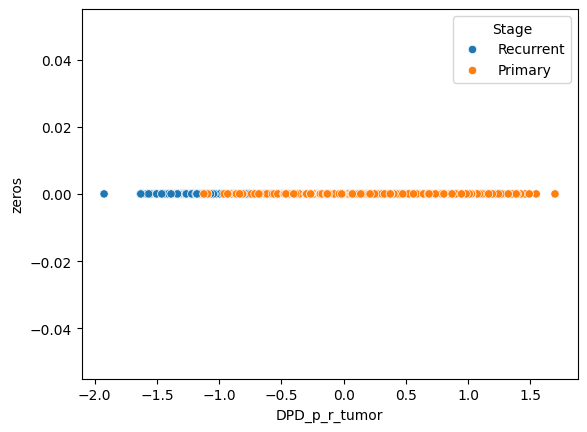

In [134]:
sns.scatterplot(x='DPD_p_r_tumor',y='zeros',data=dpd_scores_lincs,hue='Stage')

array([[<Axes: title={'center': 'DPD_p_r_tumor'}>,
        <Axes: title={'center': 'zeros'}>]], dtype=object)

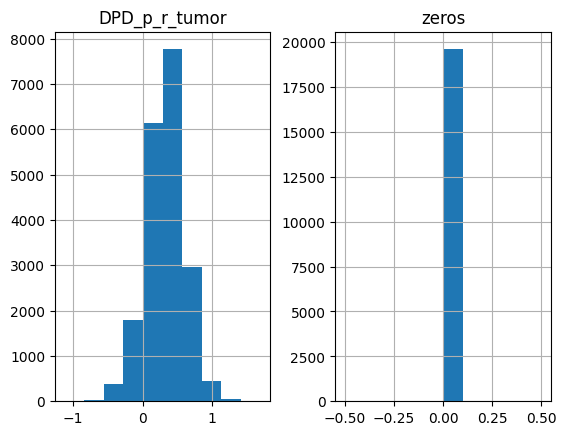

In [131]:
dpd_scores_lincs[dpd_scores_lincs['Stage']=='Primary'].hist()

array([[<Axes: title={'center': 'DPD_p_r_tumor'}>,
        <Axes: title={'center': 'zeros'}>]], dtype=object)

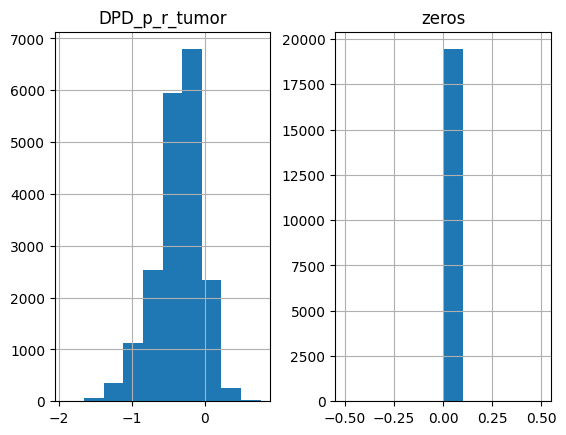

In [132]:
dpd_scores_lincs[dpd_scores_lincs['Stage']=='Recurrent'].hist()